In [144]:
import pandas as pd
import numpy as np
#rsStationList = pd.read_csv(r'/Users/aaroncao/Documents/California Wildfire Project/California_Fire_Incidents - 3169904 station list.csv')
#rsWeatherDf = pd.read_csv(r'/Users/aaroncao/Documents/California Wildfire Project/California_Fire_Incidents - 3169904 weekly summaries with missing data filled.csv')
fireDf = pd.read_csv(r'/Users/aaroncao/Documents/California Wildfire Project/California_Fire_Incidents - California_Fire_Incidents.csv')
%store -r finalWeeklyWeatherDf
%store -r stationInfoDf
rsWeatherDf = finalWeeklyWeatherDf.copy()
rsStationList = stationInfoDf.copy()
rsFireDf = fireDf[fireDf['Counties'] == 'Riverside']
print(rsWeatherDf.head())

        DATE      STATION  AWND      Begin        End  AVG PRECIP  \
0 2012-12-30  US1CARV0002   0.0 2012-12-30 2013-01-05    0.000000   
1 2013-01-06  US1CARV0002   0.0 2013-01-06 2013-01-12    0.054286   
2 2013-01-13  US1CARV0002   0.0 2013-01-13 2013-01-19    0.000000   
3 2013-01-20  US1CARV0002   0.0 2013-01-20 2013-01-26    0.318571   
4 2013-01-27  US1CARV0002   0.0 2013-01-27 2013-02-02    0.057143   

   TOTAL PRECIP  AVG SNOW  TOTAL SNOW   AVG TEMP  AVG MAX TEMP  MAX TEMP  \
0          0.00  2.500000        0.00   0.000000      0.000000      69.0   
1          0.38  0.250000        0.38  45.857143     60.714286      76.0   
2          0.00  0.000000        0.00  51.285714     71.428571      79.0   
3          2.23  0.000000        2.23  57.714286     69.571429      82.0   
4          0.40  0.833333        0.40  54.142857     70.142857      78.0   

   AVG MIN TEMP  MIN TEMP      TAVG2   LATITUDE  LONGITUDE  ELEVATION  
0      0.000000      33.0   0.000000  33.763056   -116.7

In [145]:
rsFireDf = rsFireDf[['Counties','Started','Extinguished','Latitude','Longitude','MajorIncident','AcresBurned']]
rsFireDf['Started'] = rsFireDf['Started'].str[:10]
rsFireDf['Extinguished'] = rsFireDf['Extinguished'].str[:10]
print(rsFireDf.head())

     Counties     Started Extinguished   Latitude   Longitude  MajorIncident  \
2   Riverside  2013-07-15   2013-07-30  33.709500 -116.728850          False   
6   Riverside  2013-08-07   2013-08-12  33.861570 -116.904270           True   
16  Riverside  2013-05-01   2013-05-04  34.288877 -116.941311           True   
24  Riverside  2013-08-05   2013-08-09  33.622360 -117.402880          False   
35  Riverside  2013-05-04   2013-05-05  33.894055 -116.855019          False   

    AcresBurned  
2       27531.0  
6       20292.0  
16       3166.0  
24       1383.0  
35        510.0  


In [146]:
from math import sin, cos, sqrt, atan2, radians
def isWithinRadius(radius, lat1, lon1, lat2, lon2): #KILOMETERS
    # Approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    if (distance<=radius):
        return True
    return False
def distBetweenCoord(lat1, lon1, lat2, lon2): #KILOMETERS
    # Approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance

In [147]:
rsCombinedDf = rsWeatherDf[['STATION', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE','AWND','AVG PRECIP','TOTAL PRECIP','AVG SNOW','TOTAL SNOW','AVG TEMP','AVG MAX TEMP','MAX TEMP','AVG MIN TEMP','MIN TEMP','TAVG2', 'Begin', 'End']]

rsCombinedDf = rsCombinedDf.drop(columns=['DATE'])
#print(rsCombinedDf.head())
print(rsCombinedDf.columns)

Index(['STATION', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'AWND', 'AVG PRECIP',
       'TOTAL PRECIP', 'AVG SNOW', 'TOTAL SNOW', 'AVG TEMP', 'AVG MAX TEMP',
       'MAX TEMP', 'AVG MIN TEMP', 'MIN TEMP', 'TAVG2', 'Begin', 'End'],
      dtype='object')


In [148]:
rsStationList.reset_index(inplace=True)
rsStationList = rsStationList[['STATION', 'LATITUDE', 'LONGITUDE']]
print(rsStationList)

        STATION   LATITUDE   LONGITUDE
0   US1CARV0002  33.763056 -116.735000
1   US1CARV0003  33.821200 -116.397800
2   US1CARV0004  33.985460 -116.541467
3   US1CARV0005  33.752700 -116.919600
4   US1CARV0006  33.734600 -117.431500
..          ...        ...         ...
69  USW00023119  33.900000 -117.250000
70  USW00023158  33.618760 -114.714510
71  USW00053151  33.439200 -117.190400
72  USW00053175  33.897650 -117.602430
73  USW00093138  33.822160 -116.504330

[74 rows x 3 columns]


In [149]:
def findClosestStationOLD(lat1, lon1): #is faster but not as cool as numpy
    stationInfoArr = rsStationList.to_numpy()
    num_rows = np.shape(stationInfoArr)[0]
    distArr = [[None for x in range(2)] for y in range(num_rows)] # 2 is width(items per list), num_rows is height(number of lists)
    #distArr = np.empty([num_rows, 2], dtype=object) # goes by np.empty(number of lists, items per list), backwards of previous line
    for i in range(num_rows):
        distArr[i][0] = stationInfoArr[i][0] #FIX: empty numpy array is filled with floats so cannot replace with string right away?
        lat2 = stationInfoArr[i][1]
        lon2 = stationInfoArr[i][2]
        dist = distBetweenCoord(lat1, lon1, lat2, lon2)
        distArr[i][1] = dist
    closestStation = ''
    closestDistance = 50000 #km
    for i in range(num_rows):
        currStation = distArr[i][0]
        currDistance = distArr[i][1]
        if currDistance<closestDistance:
            closestStation = currStation
            closestDistance = currDistance
    #indexOfSmallestStation = np.argmin(distArr[:,1]) # [:,1] slices to only take the second column
    #closestStation = distArr[indexOfSmallestStation][0]
    return closestStation

def findClosestStation(lat1, lon1):
    stationInfoArr = rsStationList.to_numpy()
    num_rows = np.shape(stationInfoArr)[0]
    #distArr = [[None for x in range(2)] for y in range(num_rows)] # 2 is width(items per list), num_rows is height(number of lists)
    distArr = np.empty([num_rows, 2], dtype=object) # goes by np.empty(number of lists, items per list), backwards of previous line
    for i in range(num_rows):
        distArr[i][0] = stationInfoArr[i][0] #FIX: empty numpy array is filled with floats so cannot replace with string right away?
        lat2 = stationInfoArr[i][1]
        lon2 = stationInfoArr[i][2]
        dist = distBetweenCoord(lat1, lon1, lat2, lon2)
        distArr[i][1] = dist
    #closestStation = ''
    #closestDistance = 50000 #km
    #for i in range(num_rows):
    #    currStation = distArr[i][0]
    #    currDistance = distArr[i][1]
    #    if currDistance<closestDistance:
    #        closestStation = currStation
    #        closestDistance = currDistance
    indexOfSmallestStation = np.argmin(distArr[:,1]) # [:,1] slices to only take the second column
    closestStation = distArr[indexOfSmallestStation][0]
    return closestStation

def findAllStationsInRange(radius, lat1, lon1):
    stationInfoArr = rsStationList.to_numpy()
    num_rows = np.shape(stationInfoArr)[0]
    #distArr = [[None for x in range(2)] for y in range(num_rows)] # 2 is width(items per list), num_rows is height(number of lists)
    distArr = np.empty([num_rows, 2], dtype=object) # goes by np.empty(number of lists, items per list), backwards of previous line
    for i in range(num_rows):
        distArr[i][0] = stationInfoArr[i][0]
        lat2 = stationInfoArr[i][1]
        lon2 = stationInfoArr[i][2]
        dist = distBetweenCoord(lat1, lon1, lat2, lon2)
        distArr[i][1] = dist
    
    returnArr = []

    for i in range(num_rows):
        currStation = distArr[i][0]
        currDistance = distArr[i][1]
        if currDistance<radius:
            returnArr.append(currStation)

    #TEST IF THIS NEXT SECTION HELPS

    if not returnArr:  #check if no station within range then get closest station
    #    indexOfSmallestStation = np.argmin(distArr[:,1]) # [:,1] slices to only take the second column
    #    returnArr.append(distArr[indexOfSmallestStation][0])
        returnArr.append('no station within radius')
    

    return returnArr


In [150]:
#rsCombinedDf['fire'] = "None"
rsCombinedDf['fire'] = 'None'
print(rsCombinedDf.head())

       STATION   LATITUDE  LONGITUDE  ELEVATION  AWND  AVG PRECIP  \
0  US1CARV0002  33.763056   -116.735     1927.9   0.0    0.000000   
1  US1CARV0002  33.763056   -116.735     1927.9   0.0    0.054286   
2  US1CARV0002  33.763056   -116.735     1927.9   0.0    0.000000   
3  US1CARV0002  33.763056   -116.735     1927.9   0.0    0.318571   
4  US1CARV0002  33.763056   -116.735     1927.9   0.0    0.057143   

   TOTAL PRECIP  AVG SNOW  TOTAL SNOW   AVG TEMP  AVG MAX TEMP  MAX TEMP  \
0          0.00  2.500000        0.00   0.000000      0.000000      69.0   
1          0.38  0.250000        0.38  45.857143     60.714286      76.0   
2          0.00  0.000000        0.00  51.285714     71.428571      79.0   
3          2.23  0.000000        2.23  57.714286     69.571429      82.0   
4          0.40  0.833333        0.40  54.142857     70.142857      78.0   

   AVG MIN TEMP  MIN TEMP      TAVG2      Begin        End  fire  
0      0.000000      33.0   0.000000 2012-12-30 2013-01-05  N

In [151]:
print(rsFireDf.head())

     Counties     Started Extinguished   Latitude   Longitude  MajorIncident  \
2   Riverside  2013-07-15   2013-07-30  33.709500 -116.728850          False   
6   Riverside  2013-08-07   2013-08-12  33.861570 -116.904270           True   
16  Riverside  2013-05-01   2013-05-04  34.288877 -116.941311           True   
24  Riverside  2013-08-05   2013-08-09  33.622360 -117.402880          False   
35  Riverside  2013-05-04   2013-05-05  33.894055 -116.855019          False   

    AcresBurned  
2       27531.0  
6       20292.0  
16       3166.0  
24       1383.0  
35        510.0  


In [152]:
import datetime as dt
def isDuringWeek(beginDate, endDate, findDate): #year-month-day
    beginDate = str(beginDate)
    endDate = str(endDate)
    
    d1 = dt.datetime(int(beginDate[0:4]),int(beginDate[5:7]), int(beginDate[8:10]))
    d2 = dt.datetime(int(findDate[0:4]), int(findDate[5:7]), int(findDate[8:10]))
    d3 = dt.datetime(int(endDate[0:4]), int(endDate[5:7]), int(endDate[8:10]))
    return (d1<=d2<=d3)

#only care about fires starting for this one
def combineWithClosestStation(givenDftoCombine): #pass rsCombinedDf as param for givenDFtoCombine
    #matching

    combinedDf = givenDftoCombine.copy()

    for ind in rsFireDf.index:
        lat1 = rsFireDf.at[ind, 'Latitude']
        lon1 = rsFireDf.at[ind, 'Longitude']
        rsFireDf.at[ind,'ClosestStation'] = findClosestStation(lat1, lon1)


    combinedDf_grouped = combinedDf.groupby('STATION')
    for ind in rsFireDf.index:
        currStation = str(rsFireDf.at[ind, 'ClosestStation'])
        fireStartDate = rsFireDf.at[ind, 'Started']
        #currEndDate = rsFireDf.at[ind, 'Extinguished']
        for row_index, row in combinedDf_grouped.get_group(currStation).iterrows():
            if isDuringWeek(row['Begin'], row['End'], fireStartDate):
                fireSize = 'minor'
                if rsFireDf.at[ind, 'MajorIncident']:
                    fireSize = 'major'
                if combinedDf.at[row_index, 'fire']!='major':
                        combinedDf.at[row_index, 'fire'] = fireSize
                    
                break
    
    return combinedDf

def combineWithStationsInRange(givenDftoCombine, radius): #pass rsCombinedDf as param for givenDFtoCombine
    #matching
    
    combinedDf = givenDftoCombine.copy()
    combinedDf.reset_index(inplace=True)
    combinedDf['fire arr'] = [[] for q in range(len(combinedDf))]
    combinedDf['acres burned'] = 0
    
    #extra
    c1 = 0
    c2 = 0

    for ind in rsFireDf.index:
        lat1 = rsFireDf.at[ind, 'Latitude']
        lon1 = rsFireDf.at[ind, 'Longitude']
        stationsInRange = findAllStationsInRange(radius, lat1, lon1)

        #extra
        if (stationsInRange[-1] == 'no station within radius'):
            c1+=1
            stationsInRange.pop()
        
        rsFireDf.at[ind,'ClosestStation'] = stationsInRange
    #print(combinedDf.columns)
    combinedDf_grouped = combinedDf.groupby('STATION')
    for ind in rsFireDf.index: #loop through each fire
        
        fireStartDate = rsFireDf.at[ind, 'Started']
        #currEndDate = rsFireDf.at[ind, 'Extinguished']

        for i in range(len(rsFireDf.at[ind, 'ClosestStation'])): #change for each station
            currStation = str(rsFireDf.at[ind, 'ClosestStation'][i])

            for row_index, row in combinedDf_grouped.get_group(currStation).iterrows(): #find specific week to change
                if isDuringWeek(row['Begin'], row['End'], fireStartDate):
                    fireSize = 'minor'
                    if rsFireDf.at[ind, 'MajorIncident']:
                        fireSize = 'major'

                    if combinedDf.at[row_index, 'fire']!='major':
                        combinedDf.at[row_index, 'fire'] = fireSize
                    
                    combinedDf.at[row_index, 'fire arr'].append(fireSize)
                    combinedDf.at[row_index, 'acres burned']=combinedDf.at[row_index, 'acres burned']+rsFireDf.at[ind, 'AcresBurned']
                    #print(combinedDf.at[row_index, 'acres burned'])
                    
                    if len(combinedDf.at[row_index, 'fire arr'])>=2:    
                        c2+=1
                    
                    break
    #extra
    print('num of fires without station:', c1)
    print('num of instances with 2+ fires in the week:', c2)
    return combinedDf


In [153]:

combinedClosestDf = combineWithClosestStation(rsCombinedDf)
print("only closest station:")
print(combinedClosestDf['fire'].value_counts())


only closest station:
None     18705
minor      101
major       12
Name: fire, dtype: int64


In [154]:

combinedInRangeDf = combineWithStationsInRange(rsCombinedDf, 20)
print("stations within 20 km:")
print(combinedInRangeDf['fire'].value_counts())
print(combinedInRangeDf['fire arr'].value_counts())

#18 fires out of range of stations
#include closest station when none within radius! None:8258. minor:627. major:58.
#only ones within radius! None:8272. minor:612. major:59. WHY DOES MAJOR INCREASE???

num of fires without station: 22
num of instances with 2+ fires in the week: 141
stations within 20 km:
None     18072
minor      648
major       98
Name: fire, dtype: int64
[]                                            18072
[minor]                                         576
[major]                                          68
[minor, minor]                                   54
[major, minor]                                   15
[minor, minor, minor]                            14
[major, minor, minor]                            12
[minor, minor, minor, minor]                      3
[major, minor, major]                             3
[minor, minor, minor, minor, minor, minor]        1
Name: fire arr, dtype: int64


In [155]:

for col in combinedClosestDf.columns:
    print(col)

STATION
LATITUDE
LONGITUDE
ELEVATION
AWND
AVG PRECIP
TOTAL PRECIP
AVG SNOW
TOTAL SNOW
AVG TEMP
AVG MAX TEMP
MAX TEMP
AVG MIN TEMP
MIN TEMP
TAVG2
Begin
End
fire


In [156]:
print(combinedInRangeDf.dtypes)

index                    int64
STATION                 object
LATITUDE               float64
LONGITUDE              float64
ELEVATION              float64
AWND                   float64
AVG PRECIP             float64
TOTAL PRECIP           float64
AVG SNOW               float64
TOTAL SNOW             float64
AVG TEMP               float64
AVG MAX TEMP           float64
MAX TEMP               float64
AVG MIN TEMP           float64
MIN TEMP               float64
TAVG2                  float64
Begin           datetime64[ns]
End             datetime64[ns]
fire                    object
fire arr                object
acres burned             int64
dtype: object


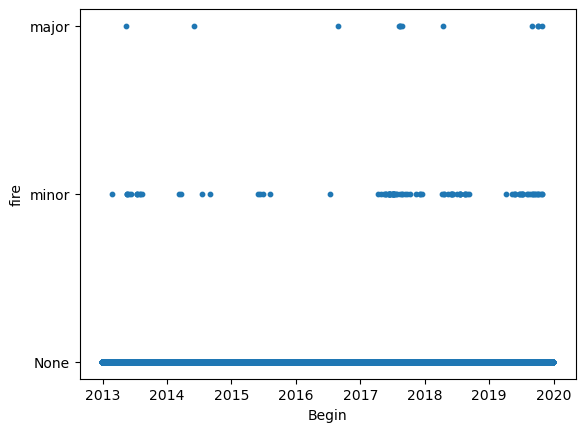

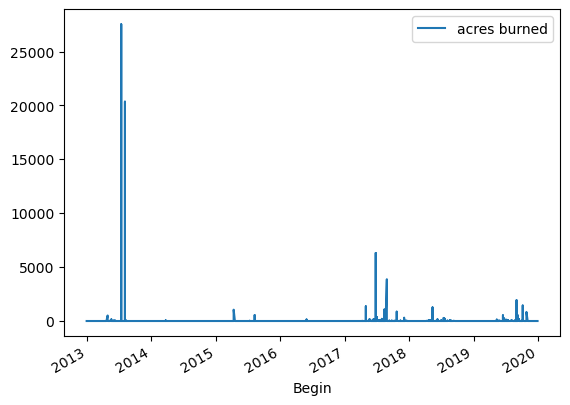

In [157]:
import matplotlib.pyplot as plt

#plotting closest df
closestPlotDf = combinedClosestDf.copy()
closestPlotDf['Begin'] = pd.to_datetime(closestPlotDf['Begin'], format='%Y-%m-%d') #convert to datetime obj
closestPlotDf = closestPlotDf[['STATION', 'Begin', 'fire', 'AVG TEMP', 'AVG MAX TEMP', 'AVG MIN TEMP']]

closestPlotDf['Month'] = pd.DatetimeIndex(closestPlotDf['Begin']).month
closestPlotDf['Year'] = pd.DatetimeIndex(closestPlotDf['Begin']).year

#for plotting the range df
rangePlotDf = combinedInRangeDf.copy()
rangePlotDf['Begin'] = pd.to_datetime(rangePlotDf['Begin'], format='%Y-%m-%d') #convert to datetime obj
rangePlotDf = rangePlotDf[['STATION', 'Begin', 'fire', 'AVG TEMP', 'acres burned']]

rangePlotDf['Month'] = pd.DatetimeIndex(rangePlotDf['Begin']).month
rangePlotDf['Year'] = pd.DatetimeIndex(rangePlotDf['Begin']).year


closestPlotDf = closestPlotDf.set_index('Begin').sort_index().reset_index()
closestPlotDf.plot.scatter(x='Begin', y='fire', s=10)
plt.show()

rangePlotDf = rangePlotDf.set_index('Begin').sort_index().reset_index()
rangePlotDf.plot(x='Begin', y='acres burned')
plt.show()
#SCATTERPLOT will be same for both  range and closest

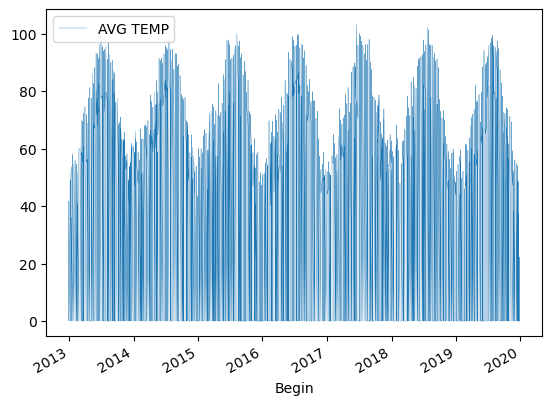

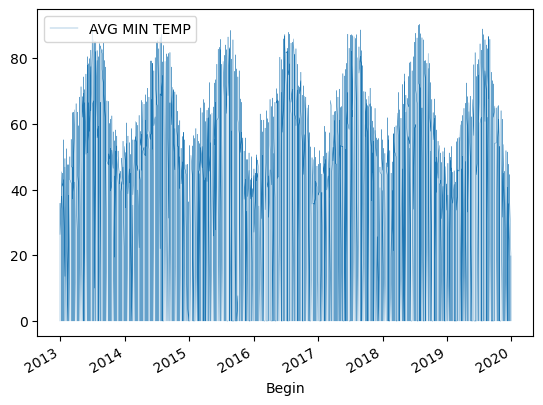

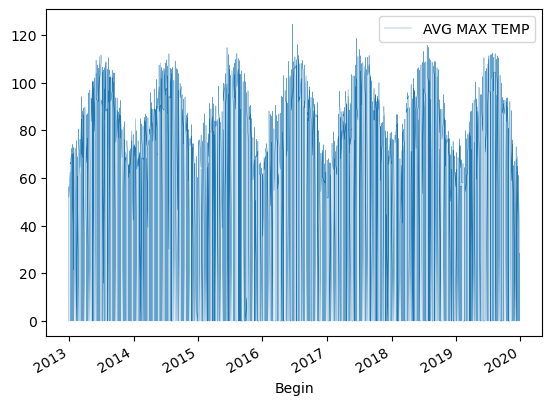

In [158]:
closestPlotDf.plot(x='Begin', y='AVG TEMP', linewidth = 0.25)
plt.show()
closestPlotDf.plot(x='Begin', y='AVG MIN TEMP', linewidth = 0.25)
plt.show()
closestPlotDf.plot(x='Begin', y='AVG MAX TEMP', linewidth = 0.25)
plt.show()


In [162]:
#closestPlotDf.groupby('STATION').plot.scatter(x='AVG MAX TEMP', y='AVG TEMP')
#groupedClosestPlotDf = closestPlotDf.groupby('STATION')
# create a grid of subplots with 1 row and 2 columns
#fig, axs = plt.subplots(nrows=7, ncols=6, figsize=(30, 40))

# iterate over each group and plot on a separate subplot
#for i, (name, group) in enumerate(groupedClosestPlotDf):
#    row, col = divmod(i,6)
#    ax = axs[row][col]  # select the (row, col) subplot
#    group.plot(x='Begin', y='AVG TEMP', label=name, ax=ax)  # plot the group
#    ax.set_title(name)  # set the subplot title
#    ax.legend()

#plt.show()

#USC00042410 has a problem

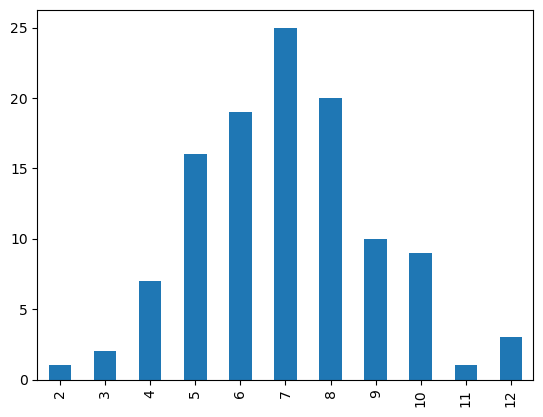

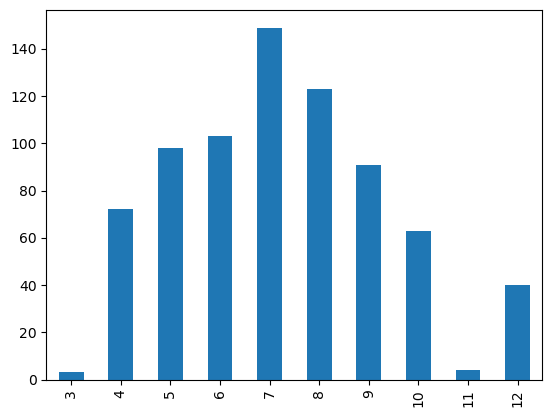

In [163]:
closestMonthBarGraph = closestPlotDf.copy()
closestMonthBarGraph = closestMonthBarGraph[closestMonthBarGraph.fire != 'None']
closestMonthBarGraph['Month'].value_counts().sort_index().plot(kind='bar')
plt.show()


rangeMonthBarGraph = rangePlotDf.copy()
rangeMonthBarGraph = rangeMonthBarGraph[rangeMonthBarGraph.fire != 'None']
rangeMonthBarGraph['Month'].value_counts().sort_index().plot(kind='bar')
plt.show()

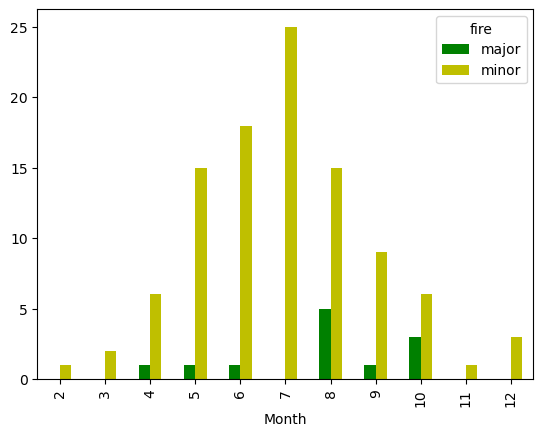

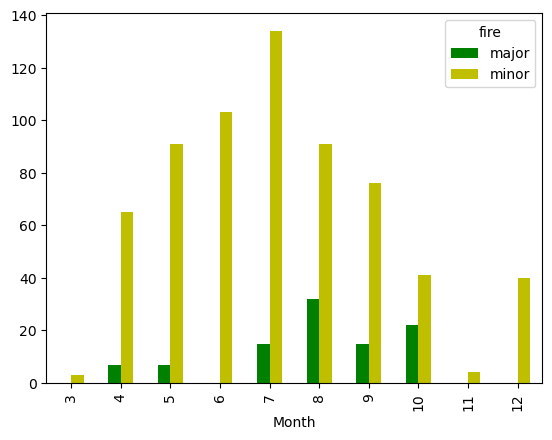

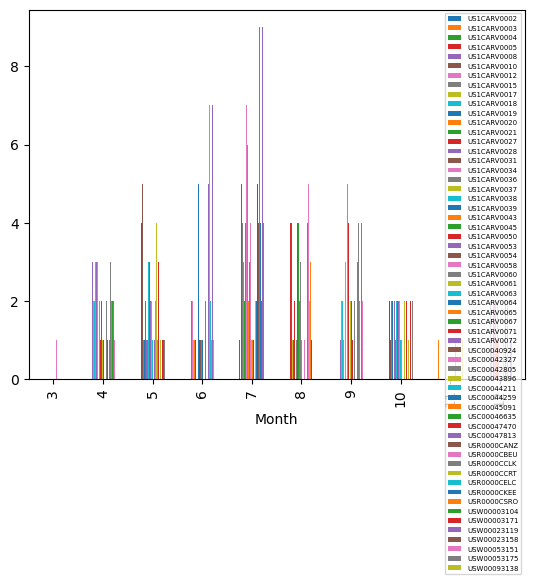

In [164]:
closestMonthBarGraph.groupby('fire').Month.value_counts().unstack(0).plot(kind='bar', color=['g','y'])
plt.show()

rangeMonthBarGraph.groupby('fire').Month.value_counts().unstack(0).plot(kind='bar', color=['g','y'])
plt.show()

rangeMonthBarGraph.groupby('STATION').Month.value_counts().unstack(0).plot(kind='bar')
plt.legend(loc='upper right', fontsize = '5')
plt.show()


In [165]:
#combinedInRangeDf.to_csv(r'/Users/aaroncao/Documents/California Wildfire Project/combinedInRangeDf.csv')

# Assuming you have a DataFrame called 'df' that you want to export
%store combinedInRangeDf

Stored 'combinedInRangeDf' (DataFrame)
